In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
df = pd.read_csv("Numerical Loan Approval Synthetic Dataset with binary outcome.csv").drop(columns=["Unnamed: 0"])

In [6]:
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df['Loan_Approval']
)
test_df_unscaled = test_df.copy()

In [8]:
num_feats = ['Annual_Income','Credit_Score','Debt_to_Income','Employment_Length','Age']
scaler = StandardScaler().fit(train_df[num_feats])
X_train = scaler.transform(train_df[num_feats])
X_test  = scaler.transform(test_df[num_feats])
y_train = train_df['Loan_Approval'].values
y_test  = test_df['Loan_Approval'].values


In [10]:
class NumDataset(Dataset):
    def __init__(self, X, y):
        # X: [N, 5] → [N, 5, 1] for RNN input
        self.X = torch.from_numpy(X).float().unsqueeze(-1)
        # y: [N] → [N, 1]
        self.y = torch.from_numpy(y).float().unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = NumDataset(X_train, y_train)
test_ds  = NumDataset(X_test,  y_test)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=8)


In [12]:
class NumRNNClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.rnn  = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # x: [B, seq_len=5, 1]
        out, h_n = self.rnn(x)      # h_n: [num_layers, B, hidden_size]
        last_h  = h_n[-1]           # [B, hidden_size]
        return self.fc(last_h)      # [B, 1] logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NumRNNClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

In [2]:
for epoch in range(1, 61):
    model.train()
    total_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    if epoch % 10 == 0:
        avg_loss = total_loss / len(train_dl.dataset)
        print(f"Epoch {epoch:02d}  Train Loss = {avg_loss:.4f}")


In [16]:
model.eval()
probs, preds, trues = [], [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        logit = model(xb).cpu()
        p = torch.sigmoid(logit).numpy().flatten()
        probs.extend(p)
        preds.extend((p > 0.5).astype(int))
        trues.extend(yb.numpy().flatten().astype(int))

acc = accuracy_score(trues, preds)
auc = roc_auc_score(trues, probs)
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test ROC AUC : {auc:.4f}")


Test Accuracy: 0.9893
Test ROC AUC : 0.9997


In [21]:
preds_df = pd.DataFrame({"pred_value": preds})

In [25]:
test_df = test_df_unscaled.drop(test_df_unscaled.columns[[-1]], axis=1)

In [27]:
merged_df = pd.concat([
    test_df.reset_index(drop=True),
    preds_df.reset_index(drop=True)
], axis=1)

In [35]:
merged_df

,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age,pred_value
0,82472.111278,730.310701,0.907336,18.383897,29,1
1,45710.190424,425.101961,0.250506,18.268317,52,0
2,72076.839314,524.687593,0.717371,17.395126,24,1
3,68264.625734,563.976071,0.387779,8.526752,31,0
4,68183.436793,815.429732,0.552186,13.605073,24,1
...,...,...,...,...,...,...
2995,90631.319429,485.611082,0.810810,11.144118,26,1
2996,96962.745954,351.293066,0.903730,17.648027,58,1
2997,107639.630554,558.880170,0.640219,1.608582,70,1
2998,72881.767311,690.713206,0.582719,4.256265,55,1


In [47]:
from scipy.stats import pointbiserialr
import numpy as np
import matplotlib.pyplot as plt

In [51]:
def r_to_cohens_d(r):
    return 2 * r / np.sqrt(1 - r**2)

# 1. Compute r, p, d for each feature
records = []
for feat in features:
    r, p = pointbiserialr(merged_df[feat], merged_df['pred_value'])
    if p < 0.05:
        d = r_to_cohens_d(r)
        records.append({
            'Feature': feat,
            'r':        r,
            'p_value':  p,
            'd':        d,
            'abs_r':    abs(r)
        })

# 2. Build DataFrame and sort by |d| descending (largest effect first)
eff_df = pd.DataFrame(records)
if eff_df.empty:
    print("No features with p < 0.05")
else:
    eff_df = eff_df.sort_values('abs_r', ascending=False).reset_index(drop=True)
    print(eff_df[['Feature','abs_r','p_value','d']])

          Feature     abs_r        p_value         d
0   Annual_Income  0.528877  6.953150e-216  1.246326
1    Credit_Score  0.467364  1.129363e-162  1.057307
2  Debt_to_Income  0.395769  4.613189e-113  0.861913
3             Age  0.038121   3.680815e-02 -0.076298


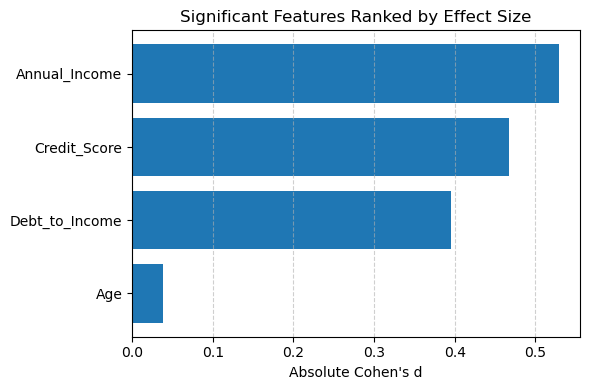

In [53]:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.barh(eff_df['Feature'], eff_df['abs_r'])
    plt.xlabel("Absolute Cohen's d")
    plt.title("Significant Features Ranked by Effect Size")
    plt.gca().invert_yaxis()  # bring largest to top
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [55]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"annual_income", "credit_score", "debt_to_income"}
    ranking = [
        "annual_income",
        "credit_score",
        "debt_to_income",
        "Age"
    ]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "Stat-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
Stat-XAI       0.75     1.0 0.25            1


In [18]:
import shap
import numpy as np
import psutil
import os
import torch.optim as optim
import matplotlib.pyplot as plt

In [56]:
def predict_proba_np(x_np):
    """
    x_np: (batch, 5) float array
    returns: (batch,) array of model's P(class=1)
    """
    model.eval()
    with torch.no_grad():
        # convert to tensor shape (batch,5,1)
        t = torch.from_numpy(x_np).float().unsqueeze(-1).to(device)
        logits = model(t)               # [batch,1]
        probs  = torch.sigmoid(logits)  # [batch,1]
    return probs.cpu().numpy().flatten()

In [58]:
bg_size = 200
idx = np.random.choice(len(X_train), size=bg_size, replace=False)
background = X_train[idx]  # shape (200,5)




In [60]:
explainer = shap.KernelExplainer(predict_proba_np, background)


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [62]:
batch_size = 512
all_shap = []

for start in range(0, X_test.shape[0], batch_size):
    end = min(start + batch_size, X_test.shape[0])
    Xb = X_test[start:end]  # (batch,5)

    mem = psutil.virtual_memory()
    print(f"Batch {start}-{end}: free RAM = {mem.available/1e9:.2f} GB")

    # nsamples trades off speed vs. accuracy
    shap_vals = explainer.shap_values(Xb, nsamples=100)
    all_shap.append(shap_vals)       # (batch,5)


Batch 0-512: free RAM = 4.88 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 512-1024: free RAM = 5.06 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1024-1536: free RAM = 5.00 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1536-2048: free RAM = 5.01 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2048-2560: free RAM = 5.02 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2560-3000: free RAM = 5.05 GB


  0%|          | 0/440 [00:00<?, ?it/s]

In [64]:
all_shap_values = np.vstack(all_shap)

In [66]:
mean_abs = pd.Series(
    np.abs(all_shap_values).mean(axis=0),
    index=num_feats
).sort_values()


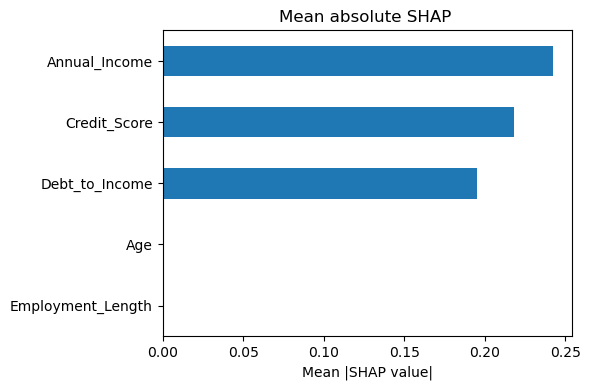

In [74]:
os.makedirs("shap", exist_ok=True)
plt.figure(figsize=(6,4))
mean_abs.plot.barh()
plt.xlabel("Mean |SHAP value|")
plt.title("Mean absolute SHAP ")
plt.tight_layout()
plt.savefig("shap/RNN_numeric_binary_shap_kernel.jpg", dpi=300)
plt.show()

In [76]:
print("Mean |SHAP value| per feature:")
print(mean_abs)

Mean |SHAP value| per feature:
Employment_Length    0.000865
Age                  0.001122
Debt_to_Income       0.195139
Credit_Score         0.218235
Annual_Income        0.242254
dtype: float64


In [78]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])




In [80]:
if __name__ == "__main__":
    # Example:
    GT = {"annual_income", "credit_score", "debt_to_income"}
    ranking = [
        "annual_income",
        "credit_score",
        "debt_to_income",
        "Age",
        "Employement_Lenght"
    ]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "SHAP-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
SHAP-XAI        0.6     1.0  0.4            1
